<center>

# Assignment 2 
## Student Name: Robert Aruta
## Student Number: 45796649

<style>
.page-break { page-break-after: always; }
</style>

<div class="page-break"></div>

## Q1

The fingerprint recognition algorithm used was the same as the jupyter notebook example. However, the algorithm was changed to handle a list of fingerprint images rather than one. A separate python script named, `fingerprint.py`, was written to handle this. The function, `read_fingerprints(filepath)`, reads every file in the directory passed by the `filepath` variable and stores it on a list. The remainder of the code in `fingerprint.py` was modified in a similar manner. This can be seen in the appendix, where the same steps done in the jupyter example was done using the `fingerprint.py` program. An additional function called, `analyse_fingerprints(filepath)`, was added so that a graphical user interface (GUI) program can pass additional images to the algorithm. This was named, `gui_init.py`. Streamlit was used to build the GUI. The first step was to initialise the fingerprint database, which is done by calling `analyse_fingerprints(None)`. The `None` variable would set the path of the `read_fingerprints()` to where the collection of fingerprint image are. After which, the fingerprint processing algorithm will be done for all the images in the directory. After the fingerprint database has been initialised, the user can now upload a file and is greeted by the interface shown in Figure 1. The uploaded file will be temporarily stored in a directory called, `target_fingerprint`. This is because the `analyse_fingerprint()` function only handles a directory and not a single image or file. Instead of creating a new function that handles the singular uploaded image. It was easier to create a separate direcory to store the uploaded file and process the image using `analyse_fingerprint()` function. The uploaded file would then be moved to the same directory as the rest of the fingerprint images that make up the database. The final output of the GUI is shown in Figure 2, which are the comparison scores of the uploaded fingerprint against the fingerprints in the database. The output is cropped if viewed with the rest of the interface. Figure 3 illustrates all the comparison scores without the rest of the interface. It can be seen that the uploaded file, `sample_1_1.png`, was not in the output table. But in Figure 4, the file was already added in the fingerprint database directory. Therefore, `sample_1_1.png` will be added to the output table after the re-initilisation of the fingerprint database as shown in Figure 5. In this case, the same file was uploaded. Hence why `sample_1_1.png` returned a value of 1 meaning a perfect match. 

<br>

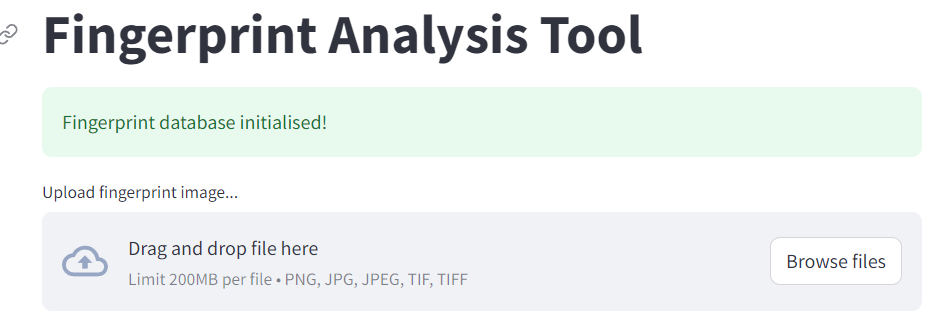
#### Figure 1: GUI 

<br>

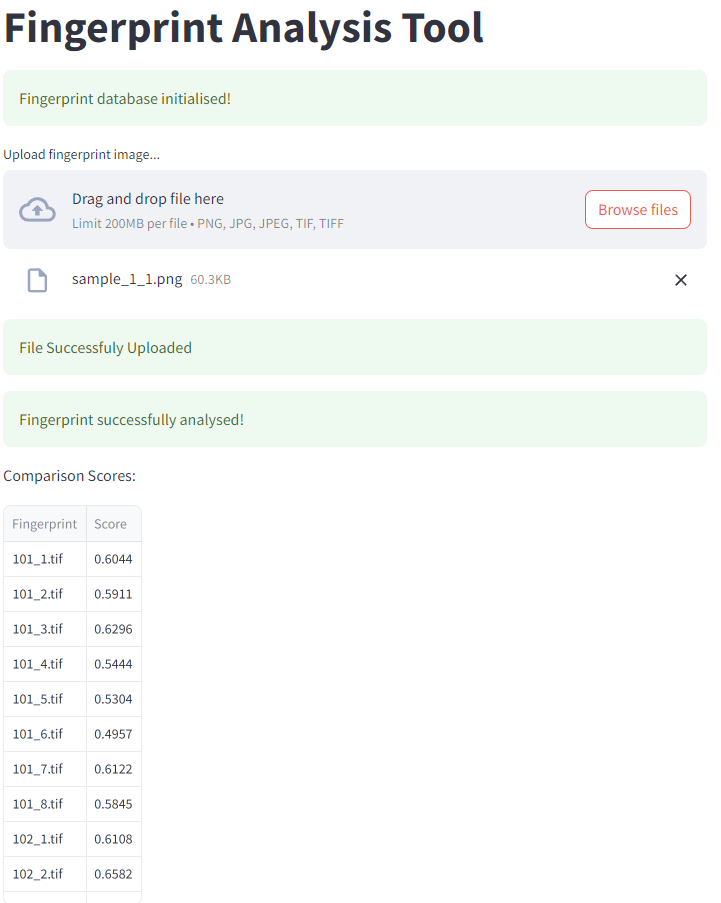
#### Figure 2: GUI Output

<br>

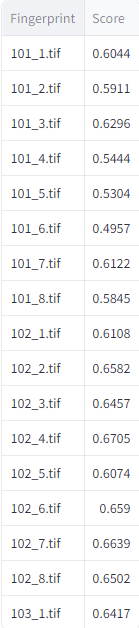
#### Figure 3: Uncropped fingerprint comparison scores 

<br>

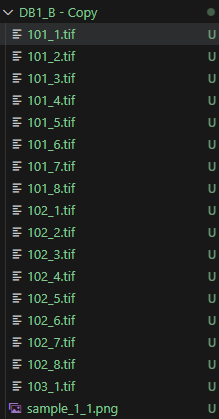
#### Figure 4: Directory after fingerprint addition of sample_1_1.png

<br>

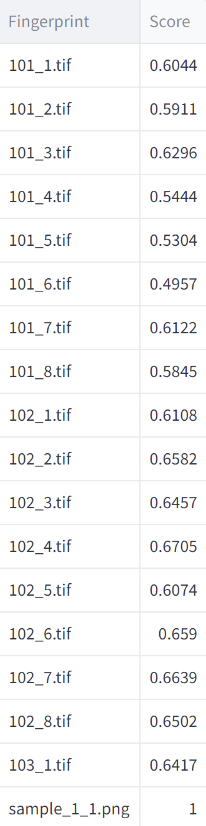
#### Figure 5: Output table after GUI re-initialisation

<style>
.page-break { page-break-after: always; }
</style>

<div class="page-break"></div>

The previous section was to demonstrate the capability of the GUI to store new fingerprints in the database and apply the same fingerprint processing algorithm. In Figure 5, it can be seen that it may seem like the fingerprint algorithm is perfect. Because, it returned a 100% match for the same fingerprint but not the rest. However, it can be seen that there are only three fingerprints in the database. Fingeprints 101, 102, 103, and the newly added sample. Therefore, if any of the copies of the same fingerprint is uploaded. The fingerprint algorithm should detect it to be a match. For example, if `101_1.tif` is uploaded.Images `101_1.tif` to `101_8.tif` should be a match. Figure 6 illustrates the output table of the algorithm when `101_4.tif` is uploaded. It can be observed that the lowest score threshold to avoid false positives is 0.6493. But if this score threshold is chosen, then `101_5.tif` will be regarded as non-matching fingerprint, which is a false negative. If the algorithm is ran on a larger fingerprint database, the same score threshold would yield false positives as shown in Figure 7. Images `109_4.tif` and `110_1.tif` are detected to be a match under the same score threshold. 

<br>

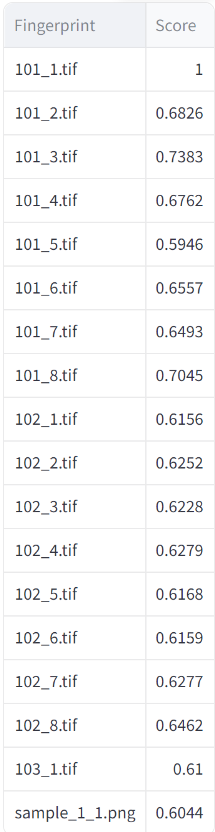
#### Figure 6: Output table when 101_1.tif is uploaded

<br>

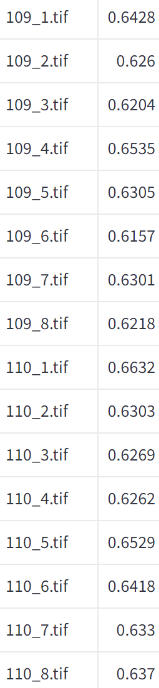
#### Figure 7: False Positive detection for 101_1.tif

### `fingerprint.py` Code

```python

from os import path
import subprocess
import threading

if not path.exists('utils.py'): # If running on colab: the first time download and unzip additional files
    
    # Run the wget command to download the file
    subprocess.run(['wget', 'https://biolab.csr.unibo.it/samples/fr/files.zip'])

    # Run the unzip command to extract the contents
    subprocess.run(['unzip', 'files.zip'])

import utils  # Run utils.py for helper functions
import math
import os
import subprocess
import numpy as np
import cv2 as cv
import csv
import matplotlib.pyplot as plt
import streamlit as st
from utils import *
from ipywidgets import interact



# Read Fingerprints in the fingerprint subdirectory
def read_fingerprints(filePath):


    #directoryPath = './A2/DB1_B/'
    #directoryPath = './DB1_B/'
    #directoryPath = './A2/fingerprint/'
    
    if filePath is not None:
        
        directoryPath = filePath
    
    else:
        
        #directoryPath = './A2/DB1_B'
        #directoryPath = './target_fingerprint'
        directoryPath = './DB1_B - Copy/'
        
    fingerprintList = []
    resizedImages = []

    for filename in os.listdir(directoryPath):
        
        filepath = os.path.join(directoryPath, filename)
        image = cv.imread(filepath, cv.IMREAD_GRAYSCALE)

        if fingerprintList is not None:

            fingerprintList.append((image, filename))

        else:
            
            print("Failed to Read image of %s\n" % filename)
    
    return fingerprintList

# Calculate the local gradient for all the fingerprints in the directory
def calc_sobel(fingerprints):
    
    GxList = []
    GyList = []
    Gx2List = []
    Gy2List = []

    # Calculate the local gradient for each fingerprins in the directory 
    for image, filename in fingerprints:
        
        # Applies the Sobel Filter to the image and append it to the list
        # for the x-direction
        Gx = cv.Sobel(image, cv.CV_32F, 1, 0)
        GxList.append(Gx)
         
        # Squares the output filtered image and appends it to the list for the
        # x-direction
        Gx2 = Gx**2
        Gx2List.append(Gx2)
        
        # Applies the Sobel Filter to the image and append it to the list
        # for the y-direction
        Gy = cv.Sobel(image, cv.CV_32F, 0, 1)
        GyList.append(Gy)

        # Squares the output filtered image and appends it to the list for the
        # y-direction
        Gy2 = Gy**2
        Gy2List.append(Gy2)
    
    
    GmList = [np.sqrt(x + y) for x, y in zip(Gx2List, Gy2List)]
    
    return GxList, GyList, Gx2List, Gy2List, GmList


def sum_Gm(GmList):
    
    sumList = []
    
    for g in GmList:
        
        sumGm = cv.boxFilter(g, -1, (25, 25), normalize = False)
        sumList.append(sumGm)
        
    return sumList

def threshold_mask(sumList):
    
    thresholdList = []
    maskList = []
    
    for i in sumList:
        
        threshold = i.max() * 0.2
        mask = cv.threshold(i, threshold, 255, cv.THRESH_BINARY)[1].astype(np.uint8)
        maskList.append(mask)
        
    return maskList

# Calculates the estimation of the local ridge orientation
def ridge_orientation(GxList, GyList, Gx2List, Gy2List):
    
    W = (23, 23)
    GxxList = []
    GyyList = []
    GxyList = []
    orientationsList = []
    strengthsList = []
    
    # Applies boxfilter for all fingerprints in the X Gradient List
    for gx2 in Gx2List:
        
        gxx = cv.boxFilter(gx2, -1, W, normalize = False)
        GxxList.append(gxx)
    
    # Applies boxfilter for all fingerprints in the Y Gradient List
    for gy2 in Gy2List:
        
        gyy = cv.boxFilter(gy2, -1, W, normalize = False)
        GyyList.append(gyy)
    
    # Applies boxfilter after multiplying X and Y gradients
    for gx, gy in zip(GxList, GyList):
        
        gxy = cv.boxFilter(gx * gy, -1, W, normalize = False)
        GxyList.append(gxy)
    
    # Substracts each X and Y gradients after being box filtered    
    diffGxxGyyList = [gxx - gyy for gxx, gyy in zip(GxxList, GyyList)]
    
    # Multiplies each element in the GxyList by 2
    G2xyList = [2 * gxy for gxy in GxyList]
    
    # Sums each X and Y gradients after being box filtered
    sumGxxGyyList = [gxx + gyy for gxx, gyy in zip(GxxList, GyyList)]
    
    
    for diffGxxGyy, g2xy in zip(diffGxxGyyList, G2xyList):
        
        orientations = (cv.phase(diffGxxGyy, -g2xy) + np.pi) / 2 # '-' to adjust for y axis direction
        orientationsList.append(orientations)
        
    
    
    for diffGxxGyy, g2xy, sumGxxGyy, gxx in zip(diffGxxGyyList, G2xyList, \
        sumGxxGyyList, GxxList):
        
        strengths = np.divide(cv.sqrt(((diffGxxGyy ** 2) + (g2xy ** 2))), \
                              sumGxxGyy, out=np.zeros_like(gxx), \
                                  where=sumGxxGyy !=0)
        strengthsList.append(strengths)
    
    return orientationsList, strengthsList

def ridge_frequency(fingerprints):
    
    regionList = []
    blurRegionList = []
    xSigList = []
    locMaxList = []
    
    for fingerprint, filename in fingerprints:
        
        #region = fingerprint[100:20, 50:150]
        # w, h = fingerprint.shape

        # startX = (w - cropWidth) // 2
        # startY = (h - cropHeight) // 2
        # endX = startX - cropWidth
        # endY = startY - cropHeight
        
        # region = fingerprint[startX:endX, 50:endY]
        # regionList.append(region)
        w, h = fingerprint.shape
        cropWidth = int(0.3 * w)
        cropHeight = int(0.3 * h)
        endRow = (h - cropHeight) // 2 
        startRow = endRow - 80
        cropWidth = int(0.3 * w)
        cropHeight = int(0.3 * h)
        middleColumn = (w - cropWidth) // 2
        startColumn = middleColumn - 25
        endColumn = middleColumn + 25
        
        region = fingerprint[startRow:endRow, startColumn:endColumn]
        regionList.append(region)
        # endX = startX + 80
        # endY = (h - cropHeight) // 2
        # endY = startY - cropHeight
        
        blurRegion = cv.blur(region, (5,5), -1)
        blurRegionList.append(blurRegion)
        
        xSignature = np.sum(blurRegion, 1)
        xSigList.append(xSignature)
    
    for xs in xSigList:
        
        localMax = np.nonzero(np.r_[False, xs[1:] > xs[:-1]] & \
            np.r_[xs[:-1] >= xs[1:], False])[0]
        
        locMaxList.append(localMax)
        
    return regionList, locMaxList, xSigList

def ridge_period(locMaxList):
    
    distList = []
    ridgePeriodList = []
    
    for locMax in locMaxList:
        
        distance = locMax[1:] - locMax[:-1]
        distList.append(distance)
        
    for distance in distList:
        
        ridgePeriod = np.average(distance)
        ridgePeriodList.append(ridgePeriod)
        
    return distList, ridgePeriodList

def gabor_bank(ridgePeriodList):
    
    orCount = 8
    gaborBankList = []
    
    for ridgePeriod in ridgePeriodList:
        
        gaborBank = [gabor_kernel(ridgePeriod, o) for o in np.arange(0, np.pi, np.pi/orCount)]
        gaborBankList.append(gaborBank)
    
    return gaborBankList

def filter_fingerprint(fingerprints, gaborBankList):
    
    filteredFPList = []
    nonfilteredFPList = []
    
    for (fp, filename), gaborBank in zip(fingerprints, gaborBankList):
        
        nfFP = 255 - fp
        nonfilteredFPList.append(nfFP)
        
        fFP = np.array([cv.filter2D(nfFP, cv.CV_32F, gb) for gb in gaborBank])
        filteredFPList.append(fFP)
        
    return filteredFPList, nonfilteredFPList 

def enhance_fingerprint(fingerprintsList, filteredFPList, orientationsList, maskList):
    
    enhancedFPList = []
    xList = []
    yList = []
    orientationIdxList = []
    filteredList = []
    orCount = 8
    
    for fingerprint, filename in fingerprintsList:
        
        y, x = np.indices(fingerprint.shape)
        xList.append(x)
        yList.append(y)
    
    for orientations in orientationsList:
        
        orientationIdx = np.round(((orientations % np.pi) / np.pi) * orCount).astype(np.int32) % orCount
        orientationIdxList.append(orientationIdx)
    
    for x, y, fFp, orientationIdx in zip(xList, yList, filteredFPList, orientationIdxList):
        
        filteredFP = fFp[orientationIdx, y, x]
        filteredList.append(filteredFP)
    
    for mask, filteredFP, (fingerprint, filename) in zip(maskList, filteredList\
        , fingerprintsList):
        
        enhancedFP = mask & np.clip(filteredFP, 0, 255).astype(np.uint8)
        enhancedFPList.append((enhancedFP, filename))
    # for fFp, orientations, mask in zip(filteredFPList, orientationsList, maskList):
        
    #     orientationIdx = np.round(((orientations % np.pi) / np.pi) * orCount).astype(np.int32) % orCount
    #     filterIdx = fFp[orientationIdx, y, x]
    #     enhancedFP = mask & np.clip(filterIdx, 0, 255).astype(np.unit8)
    #     enhancedFPList.append(enhancedFP)
        
    return enhancedFPList

def ridge_lines(enhancedFPList):
    
    ridgeLinesList = []
    
    for enhancedFP, filename in enhancedFPList:
    
        _, ridgeLines = cv.threshold(enhancedFP, 32, 255, cv.THRESH_BINARY)
        ridgeLinesList.append(ridgeLines)
    
    return ridgeLinesList

def get_skeleton(ridgeLinesList):
    
    skeletonList = []
    
    for ridgeLines in ridgeLinesList:
        
        skeleton = cv.ximgproc.thinning(ridgeLines, thinningType = cv.ximgproc.THINNING_GUOHALL)
        skeletonList.append(skeleton)
    
    return skeletonList

def compute_crossing_number(values):
    return np.count_nonzero(values < np.roll(values, -1))

def create_cn_filter():
    
    cnFilter = np.array([[  1,  2,  4],
                      [128,  0,  8],
                      [ 64, 32, 16]
                     ])
    
    return cnFilter

def get_cn(skeletonList):
    
    
    
    allEightNeighbors = [np.array([int(d) for d in f'{x:08b}'])[::-1] for x in range(256)]
    cnLUT = np.array([compute_crossing_number(x) for x in allEightNeighbors]).astype(np.uint8)
    
    skeleton01List = []
    
    for skeleton in skeletonList:
        
        skeleton01 = np.where(skeleton!=0, 1, 0).astype(np.uint8)
        skeleton01List.append(skeleton01)
    
    neighbourValsList = []
    
    for skeleton01 in skeleton01List:
        
        neighbourVals = cv.filter2D(skeleton01, -1, create_cn_filter(), borderType = cv.BORDER_CONSTANT)
        neighbourValsList.append(neighbourVals)
    
    cnList = []
    
    for skeleton, neighbourVals in zip(skeletonList, neighbourValsList):
        
        cn = cv.LUT(neighbourVals, cnLUT)
        cn[skeleton == 0] = 0
        cnList.append(cn)
        
    return neighbourValsList, allEightNeighbors, cnList

def get_minutiae(cnList):
    
    minutiaeList = []
    
    for cn in cnList:
        
        minutiae = [(x, y, cn[y, x]==1) for y, x in zip(*np.where(np.isin(cn, [1,3])))]
        minutiaeList.append(minutiae)
    
    return minutiaeList

def get_mask_distance(maskList):
    
    maskDistList = []
    
    for mask in maskList:
        
        maskDist = cv.distanceTransform(
            cv.copyMakeBorder(mask, 1, 1, 1, 1, 
                              cv.BORDER_CONSTANT), cv.DIST_C, 3)[1:-1,1:-1]
        
        maskDistList.append(maskDist)

    return maskDistList

def get_filt_minutiae(maskDistList, minutiaeList):
    
    filtMinutiaeList = []
    
    for maskDist, minutiae in zip(maskDistList, minutiaeList):
        
        filteredMinutiae = list(filter(lambda m: maskDist[m[1], m[0]]>10,
                                       minutiae))
        
        filtMinutiaeList.append(filteredMinutiae)
        
    return filtMinutiaeList

def compute_next_ridge_following_directions(prevDirection, values):
        
    nextPos = np.argwhere(values!=0).ravel().tolist()
    
    if len(nextPos) > 0 and prevDirection != 8:
        # There is a previous direction: return all the next directions, sorted
        # according to the distance from it, except the direction, if any, 
        # that corresponds to the previous position
                       
        nextPos.sort(key = lambda d: 4 - abs(abs(d - prevDirection) - 4))
        
        if nextPos[-1] == (prevDirection + 4) % 8: # the direction of the previous position is the opposite one
            nextPos = nextPos[:-1] # removes it
            
    return nextPos

def create_nd_LUT(allEightNeighbors):
    
    r2 = 2**0.5 # sqrt(2)
    
    # The eight possible (x, y) offsets with each corresponding Euclidean distance
    xySteps = [(-1, -1, r2),(0, -1, 1),(1, -1, r2), (1, 0, 1), (1, 1, r2), 
               ( 0, 1, 1), (-1, 1, r2),(-1, 0, 1)]

    ndLUT = [[compute_next_ridge_following_directions(pd, x) for pd in 
              range(9)] for x in allEightNeighbors]
    
    return xySteps, ndLUT



class MinutiaeDirections:
    
    def __init__(self, neighbourValsList, ndLUT, cnList, xySteps, fpList):
        
        self.neighbourValsList = neighbourValsList
        self.ndLUT = ndLUT
        self.cnList = cnList
        self.xySteps = xySteps
        self.fpList = fpList
        
    def follow_ridge_and_compute_angle(self, valTuple, x, y, d = 8):
        
        ndLUT = self.ndLUT
        xySteps = self.xySteps
        neighbourVals, cn = valTuple
        px, py = x, y
        length = 0.0

        # ndLUT = ridgeCtx.ndLUT
        # neighbourValsList = ridgeCtx.neighbourValsList
        # cnList = ridgeCtx.cnList
        # xySteps = ridgeCtx.xySteps
            
                
        while length < 20: # max length followed
            # print("length = %d" % length)
            # print("ndLUT: %s" % ndLUT)
            # print("py = %d" % py)
            # print("px = %d" % px)
            # print("d = %d" % d)
            #print("At start of loop - length: {}, px: {}, py: {}, d: {}"\
            #     .format(length, px, py, d))
            nextDirections = ndLUT[neighbourVals[py,px]][d]
            #print("nextDirections: {}".format(nextDirections))
            
            if len(nextDirections) == 0:
                
                #print("line 460")
                break
            
            # Need to check ALL possible next directions
            if (any(cn[py + xySteps[nd][1], px + xySteps[nd][0]] != 2 for nd 
                    in nextDirections)):
                #print("line 466")
                break # another minutia found: we stop here
            
            # Only the first direction has to be followed

            d = nextDirections[0]
            ox, oy, l = xySteps[d]
            #print("Before update - ox: {}, oy: {}, l: {}, px: {}, py: {}"\
            #     .format(ox, oy, l, px, py))
            px += ox ; py += oy ; length += l

            #print("After update - px: {}, py: {}, length: {}".\
                # format(px, py, length))

            # check if the minimum length for a valid direction has been reached

        return math.atan2(-py+y, px-x) if length >= 10 else None

    def valid_minutiae(self, filtMinutiaeList):
        
        #print("line 486")
        ndLUT = self.ndLUT
        neighbourValsList = self.neighbourValsList
        cnList = self.cnList
        xySteps = self.xySteps
        fpList = self.fpList
        
        validMinutiaeList = []
        
        for filteredMinutiae, neighbourVals, cn, (fingerprints, filename) \
            in zip(filtMinutiaeList, neighbourValsList, cnList, fpList):
                
            validMinutiae = []
            
            for (x, y, term) in filteredMinutiae:
                

                d = None
        
                if term: # termination: simply follow and compute the direction
                    
                    #print("line 503")
                    d = self.follow_ridge_and_compute_angle((neighbourVals, cn)
                                                       , x, y)

                    
                else: # bifurcation: follow each of the three branches
                    
                    # 8 means: no previous direction
                    
                    dirs = ndLUT[neighbourVals[y,x]][8]
                        
                    if len(dirs)==3: # only if there are exactly three branches
                        
                        #print("line 516")
                        angles = [self.follow_ridge_and_compute_angle \
                                ((neighbourVals, cn), x + xySteps[d][0], \
                                    y + xySteps[d][1], d) for d in dirs]

                        if all(a is not None for a in angles):
                            
                            a1, a2 = min(((angles[i], \
                                        angles[(i + 1) % 3]) \
                                        for i in range(3)), key=lambda \
                                        t: angle_abs_difference(t[0], t[1]))
                            
                            
                            d = angle_mean(a1, a2)  
                                        
                if d is not None:
                    
                    validMinutiae.append((x, y, term, d))

            validMinutiaeList.append((validMinutiae, filename))
                
        # with open('Valid Minutiae.csv', 'w', newline='') as file:
        #     writer = csv.writer(file)
        #     # Write all rows at once
        #     writer.writerows(validMinutiaeList)
            
        return validMinutiaeList
    
class LocalStructs:
    
    def __init__ (self, validMinutiaeList):
        
        self.mccRadius = 70
        self.mccSize = 16
        self.g = 2 * self.mccRadius / self.mccSize
        self.x = np.arange(self.mccSize) * self.g - (self.mccSize / 2) * \
            self.g + self.g / 2
        self.y = self.x[..., np.newaxis]
        self.iy, self.ix = np.nonzero(self.x**2 + self.y**2 <= \
            self.mccRadius**2)
        self.refCellCoords = np.column_stack((self.x[self.ix], self.x[self.iy]))
        self.mccSigmaS = 7.0
        self.mccTauPsi = 400.0
        self.mccMuPsi = 1e-2
        
        self.validMinutiaeList = validMinutiaeList
        
    def Gs(self, tSqr):
        # Gaussian function with zero mean and mcc_sigma_s standard deviation,
        # see eq. (7) in MCC paper
        return np.exp(-0.5 * tSqr / (self.mccSigmaS**2)) / (math.tau**0.5 * self.mccSigmaS)
    
    def Psi(self, v):
        # Sigmoid function that limits the contribution of dense minutiae 
        # clusters, see eq. (4)-(5) in MCC paper
        return 1. / (1. + np.exp(-self.mccTauPsi * (v - self.mccMuPsi)))
        
    def thread_calc_cell_coords(self, xy):
        
        cellCoords = np.transpose(rot@self.refCellCoords.T + \
                xy[:, :, np.newaxis], [0, 2, 1])
        
        return cellCords
    
    def create_local_structs(self):
        
        xydList = []
        
        for validMinutiae, _ in self.validMinutiaeList:
            
            xyd = np.array([(x, y, d) for x, y, _, d in validMinutiae])
            xydList.append(xyd)
            
        dCosList = []
        dSinList = []
        
        for xyd in xydList:
            
            dCos, dSin = np.cos(xyd[:, 2]).reshape((-1, 1, 1)), \
                np.sin(xyd[:, 2]).reshape((-1, 1, 1))
                
            dCosList.append(dCos)
            dSinList.append(dSin)
            
        rotList = []
        
        for dCos, dSin in zip(dCosList, dSinList):
            
            rot = np.block([[dCos, dSin], [-dSin, dCos]])
            rotList.append(rot)
        
        xyList = []
        
        for xyd, (_, filename) in zip(xydList, self.validMinutiaeList):
            
            xy = xyd[:, :2]
            xyList.append((xy, filename))
            
        #xyArray = np.concatenate(xyList, axis = 0)
        
        localStructsList = []
        distsList = []
        
        for (xy, filename), rot in zip(xyList, rotList):
            
            cellCoords = np.transpose(rot@self.refCellCoords.T + \
                xy[:, :, np.newaxis], [0, 2, 1])

            dists = np.sum((cellCoords[:, :, np.newaxis, :] - xy) ** 2, -1)
            cs = self.Gs(dists)
            diagIndices = np.arange(cs.shape[0])
            cs[diagIndices, :, diagIndices] = 0
            localStructs = self.Psi(np.sum(cs, -1))
            localStructsList.append((localStructs, filename))
            
        return localStructsList
    
class CompareFingerprint:
    
    def __init__ (self, fingerprintsList, validMinutiaeList, localStructsList):
        
        self.fingerprintsList = fingerprintsList
        self.validMinutiaeList = validMinutiaeList
        self.localStructsList = localStructsList
    
    def compare_fingerprints(self, target):
        pass
    
def print_wd():
    # Get the current working directory
    currentDirectory = os.getcwd()

    # Print the current working directory
    print(currentDirectory)

def analyse_fingerprints(filepath):

    fingerprintsList = read_fingerprints(filepath)
    GxList, GyList, Gx2List, Gy2List, GmList = calc_sobel(fingerprintsList)
    sumGm = sum_Gm(GmList)
    maskList = threshold_mask(sumGm)
    orientationsList, strengthsList = ridge_orientation(GxList, GyList,\
        Gx2List, Gy2List)
    
    regionList, locMaxList, xSigList = ridge_frequency(fingerprintsList)
    distanceList, ridgePeriodList = ridge_period(locMaxList)
    gaborBankList = gabor_bank(ridgePeriodList)
    fFPList, nfFBList = filter_fingerprint(fingerprintsList, gaborBankList)
    enhancedFPList = enhance_fingerprint(fingerprintsList, fFPList, \
        orientationsList, maskList)
    
    ridgeLinesList = ridge_lines(enhancedFPList)
    skeletonList = get_skeleton(ridgeLinesList)
    neighbourValsList, allEightNeighbors, cnList = get_cn(skeletonList)
    minutiaeList = get_minutiae(cnList)
    maskDistList = get_mask_distance(maskList)
    filtMinutiaeList = get_filt_minutiae(maskDistList, minutiaeList)
    xySteps, ndLUT = create_nd_LUT(allEightNeighbors)
    classMinutiaeDir = MinutiaeDirections(neighbourValsList, ndLUT, \
        cnList, xySteps, fingerprintsList)
    
    validMinutiaeList = classMinutiaeDir.valid_minutiae(filtMinutiaeList)
    classLocalStructs = LocalStructs(validMinutiaeList)
    localStructsList = classLocalStructs.create_local_structs()
    
    if filepath is not None:
        
        st.success('Fingerprint successfully analysed!')
    
    else:
        
        st.success('Fingerprint database initialised!')
    
    return localStructsList
    
def main():
    pass
    # print_wd()
    # readFingerPrints = read_fingerprints()
    # GxList, GyList, Gx2List, Gy2List, GmList = calc_sobel(readFingerPrints)
    # Gx = GxList[0]
    # _, filename = readFingerPrints[0]
    # sumGm = sum_Gm(GmList)
    # thres = threshold_mask(sumGm)
    # plt.imshow(thres[0], cmap='gray')  # You can specify the colormap to 'gray' for grayscale images
    # plt.title(f'Integral Gradient Magnitude of {filename}')
    # plt.show()
    # orientationsList, strengthsList = ridge_orientation(Gx2List, Gy2List)
    
    # cv.imshow('', orientationsList[0])
    
    # while True:

    #     if cv.waitKey(1) & 0xFF == ord('q'):
            
    #         cv.destroyAllWindows()
    #         break
        
if __name__ == "__main__":
    main()




<style>
.page-break { page-break-after: always; }
</style>

<div class="page-break"></div>

### `gui_init.py` Code

```python
from os import path
import subprocess
import threading
import streamlit as st
import cv2 as cv

if not path.exists('utils.py'): # If running on colab: the first time download and unzip additional files
    
    # Run the wget command to download the file
    subprocess.run(['wget', 'https://biolab.csr.unibo.it/samples/fr/files.zip'])

    # Run the unzip command to extract the contents
    subprocess.run(['unzip', 'files.zip'])

import utils  # Run utils.py for helper functions
import fingerprint as fp
import math
import os
import subprocess
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import streamlit as st
from utils import *
from ipywidgets import interact


###################
# Run the fingerprint analysis methodology on the fingerprint database
def fingerprint_db_init():
    
    fingerprintsList = fp.read_fingerprints()
    GxList, GyList, Gx2List, Gy2List, GmList = fp.calc_sobel(fingerprintsList)
    sumGm = fp.sum_Gm(GmList)
    maskList = fp.threshold_mask(sumGm)
    orientationsList, strengthsList = fp.ridge_orientation(GxList, GyList,\
        Gx2List, Gy2List)
    
    regionList, locMaxList, xSigList = fp.ridge_frequency(fingerprintsList)
    distanceList, ridgePeriodList = fp.ridge_period(locMaxList)
    gaborBankList = fp.gabor_bank(ridgePeriodList)
    fFPList, nfFBList = fp.filter_fingerprint(fingerprintsList, gaborBankList)
    enhancedFPList = fp.enhance_fingerprint(fingerprintsList, fFPList, \
        orientationsList, maskList)
    
    ridgeLinesList = fp.ridge_lines(enhancedFPList)
    skeletonList = fp.get_skeleton(ridgeLinesList)
    neighbourValsList, allEightNeighbors, cnList = fp.get_cn(skeletonList)
    minutiaeList = fp.get_minutiae(cnList)
    maskDistList = fp.get_mask_distance(maskList)
    filtMinutiaeList = fp.get_filt_minutiae(maskDistList, minutiaeList)
    xySteps, ndLUT = fp.create_nd_LUT(allEightNeighbors)
    classMinutiaeDir = fp.MinutiaeDirections(neighbourValsList, ndLUT, \
        cnList, xySteps)
    
   
    validMinutiaeList = classMinutiaeDir.valid_minutiae(filtMinutiaeList)
    
    print("FINGERPRINT DATABASE INITIALIZED")
    
    return 0

# Label the fingerprint based on the score
def label_fingerprint(scoresList):
    
    matchList = [] 
    notMatchList = []
    
    for score in scoresList:
        
        if score >= 0.5:
            
            matchList.append(score)
            
        else:
            
            notMatchList.append(score)
            
    if TPList and FPList is not None:
        
        TPR = len(matchList) / (len(matchList) + len(notMatchListt)) 
        
    return TPR

    
    
# Compare the uploaded fingerprint against the database
def compare_fingerprints(localStructsList, targetStructs): #databaseTuple, targetTuple
    
    #localStructsList = databaseTuple
    #ls1 = targetTuple
    ls1, targetName = targetStructs[0]
    scoresList = []
    
    for localStructs, filename in localStructsList:
        
        dists = np.linalg.norm(localStructs[:, np.newaxis, :] - ls1, axis = -1)
        
        # Normalize as in eq. (17) of MCC paper
        dists /= np.linalg.norm(localStructs, axis = 1)[:,np.newaxis] + \
            np.linalg.norm(ls1, axis = 1)
            
        numPairs = 5 # For simplicity: a fixed number of pairs
        pairs = np.unravel_index(np.argpartition(dists, numPairs, None)[:numPairs], \
            dists.shape)
        
        score = 1 - np.mean(dists[pairs[0], pairs[1]])
        scoresList.append((filename, score))
    
    # Convert scores to pandas Dataframe for streamlit
    scoreDataFrame = pd.DataFrame(scoresList, columns = ['Fingerprint', 'Score'])
    
    # Sort the table by Fingerprint name order
    scoreDataFrame.sort_values('Fingerprint', inplace = True)
        
    return scoreDataFrame

def main():
    
    st.title('Fingerprint Analysis Tool')
    
    # File path for target fingerprints to be analysed by the user
    directoryPath = './target_fingerprint'
    
    # Initialise fingerprint database
    localStructsList = fp.analyse_fingerprints(None)
    # fingerprintsList, validMinutiaeList, localStructsList = \
    #     fp.analyse_fingerprints(None)
    
    #databaseTuple = (fingerprintsList, validMinutiaeList, localStructsList)
    # col1, col2, col3 = st.columns(3)
    
    # with col1:
        
    #     st.image(fingerprintsList[0][0], caption = 'Fingerprint', use_column_width = True)
    
    # with col2:
        
    #     drawMinutiae = draw_minutiae(fingerprintsList[0][0], validMinutiaeList[0])
    #     st.image(drawMinutiae, caption = 'Fingerprint', use_column_width = True)
        
    # with col3:
    #     pass
    #     #st.image(localStructsList[0], caption = 'Fingerprint', use_column_width = True)
   


    uploadedFile = st.file_uploader("Upload fingerprint image...", \
        type = ["png", "jpg", "jpeg", "tif"])

    if uploadedFile is not None:
        
        filePath = os.path.join(directoryPath, uploadedFile.name)
        
        with open(filePath, "wb") as f:
            
            f.write(uploadedFile.getbuffer())
        
        st.success('File Successfuly Uploaded')
        ls1 = fp.analyse_fingerprints(directoryPath)
        #targetTuple = (f1, m1, ls1)
        #score = compare_fingerprints(databaseTuple, targetTuple)
        score = compare_fingerprints(localStructsList, ls1)
        st.write("Comparison Scores: ")
        st.dataframe(score, hide_index = True)
        #st.image(f)
        # move the uploaded file to the fingerprint database directory
        newFilePath = os.path.join('./DB1_B - Copy', uploadedFile.name)
        os.rename(filePath, newFilePath)
        #st.success('File Moved to DB1_B directory')
        encodeFile = np.asarray(bytearray(uploadedFile.read()), dtype=np.uint8)
        decodeFile = cv.imdecode(encodeFile, cv.IMREAD_GRAYSCALE)
        #st.image(decodeFile, channels="BGR", caption='Uploaded Fingerprint', use_column_width=True)
        #print(decodeFile.min(). decodeFile.max())
        #analyse_target_fingerprint(decodeFile)
        
        
        
if __name__ == "__main__":
    main()
    

<style>
.page-break { page-break-after: always; }
</style>

<div class="page-break"></div>

## Appendix

In [507]:
from os import path

if not path.exists('utils.py'): # If running on colab: the first time download and unzip additional files
    !wget https://biolab.csr.unibo.it/samples/fr/files.zip
    !unzip files.zip
    
    
import utils  # Run utils.py for helper functions
import fingerprint as fp
import gui_init as gui
import math
import os
import importlib
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from utils import *
from ipywidgets import interact

%cd /workspaces/fingerprint/

/workspaces/fingerprint


In [508]:
importlib.reload(fp)
importlib.reload(utils)
fp.print_wd()

/workspaces/fingerprint


,,
Gx**2 102_5.tif,Gy**2 of 102_5.tif,Gradient Magnitude 102_5.tif

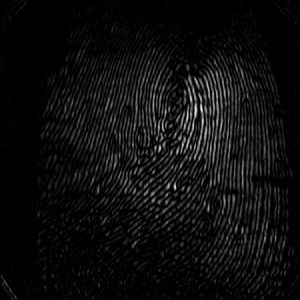
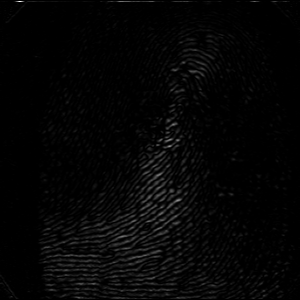
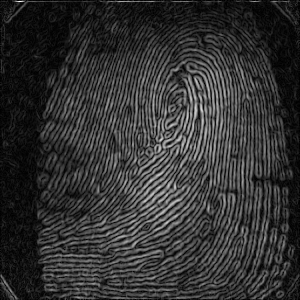

(300, 300)


In [509]:
#Show the resultant image for the first element of the database
fingerprintsList = fp.read_fingerprints(None)
fingerprint = fingerprintsList[0][0]
GxList, GyList, Gx2List, Gy2List, GmList = fp.calc_sobel(fingerprintsList)
_, filename = fingerprintsList[0]

show((Gx2List[0], f'Gx**2 {filename}'), (Gy2List[0], f'Gy**2 of {filename}'), (GmList[0], f'Gradient Magnitude {filename}'))

print(fingerprintsList[0][0].shape)

In [510]:
# w, h = fingerprintsList[0][0].shape
# fingerprint = fingerprintsList[0][0]
# cropWidth = int(0.3 * w)
# cropHeight = int(0.3 * h)
# endRow = (h - cropHeight) // 2 
# startRow = endRow - 80
# rowLength = len(fingerprint[startRow:endRow])
# # startY = (h - cropHeight) // 2
# # endX = startX + 80
# middleColumn = (w - cropWidth) // 2
# startColumn = middleColumn - 25
# endColumn = middleColumn + 25
# columnLen = len(fingerprint[startColumn:endColumn])
# endY = (h - cropHeight) // 2
# #endY = startY + cropHeight
# print(startRow, endRow, startColumn, endColumn)
# region = fingerprint[startRow:endRow, startColumn:endColumn]

# print("Row Lenght = %d" % rowLength)
# print("Column Length = %d" % columnLen)
# show(region)

""
Integral of the Gradient Magnitude of 102_5.tif

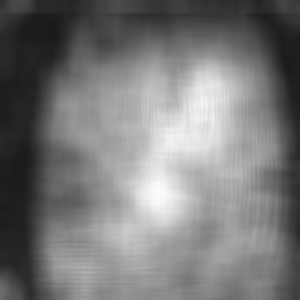

In [511]:
# Integral over a square window for 102_5.tif
sumGm = fp.sum_Gm(GmList)

show(sumGm[0], f'Integral of the Gradient Magnitude of {filename}')

,,
Original Image of 102_5.tif,Threshold Mask of 102_5.tif,Mask Backprojected to the Original Image of 102_5.tif

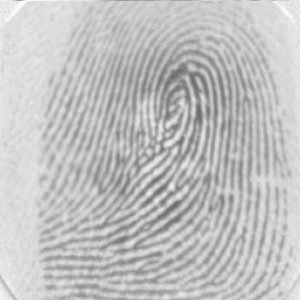
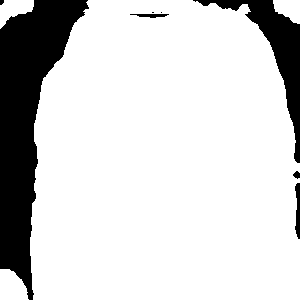
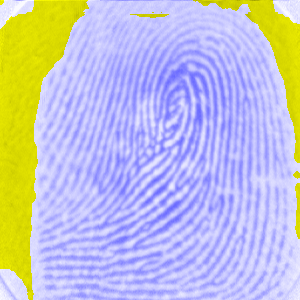

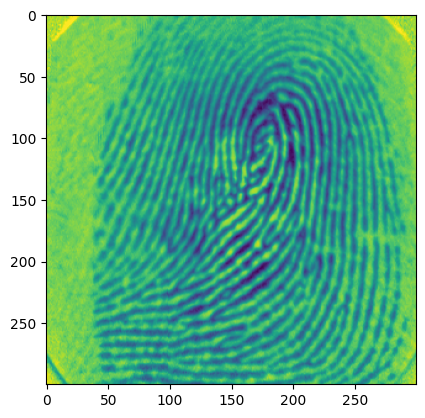

(300, 300)
(300, 300)


In [512]:
# Simple thresholding for segmenting the fingerprint pattern

maskList = fp.threshold_mask(sumGm)
show((fingerprint, f'Original Image of {filename}'), (maskList[0], f'Threshold Mask of {filename}'), 
     (cv.merge((maskList[0], fingerprint, fingerprint)), f'Mask Backprojected to the Original Image of {filename}'))
plt.imshow(fingerprintsList[0][0])
plt.show()
print(fingerprint.shape)
print(maskList[0].shape)
#print(cv.merge((maskList[0], fingerprint, fingerprint)).shape)

""
Orientation Image 102_5.tif

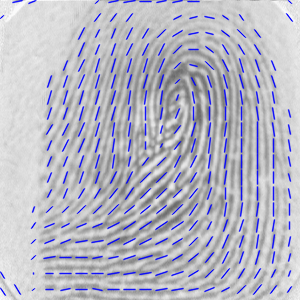

In [513]:
orientationsList, strengthsList = fp.ridge_orientation(GxList, GyList, Gx2List, Gy2List)
show((draw_orientations(fingerprint, orientationsList[0], strengthsList[0], maskList[0], 1, 16)), 
     f'Orientation Image {filename}')


""
""

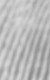

[9716 9723 9720 9704 9691 9685 9680 9682 9697 9719 9730 9737 9745 9740
 9728 9722 9722 9730 9729 9736 9738 9731 9721 9723 9714 9691 9665 9608
 9538 9454 9383 9330 9287 9270 9273 9277 9283 9288 9283 9255 9220 9174
 9111 9050 9003 8965 8934 8925 8921 8943 8968 8995 9021 9038 9035 9036
 9019 9002 9006 9022 9050 9089 9127 9156 9165 9142 9102 9049 8983 8926
 8888 8882 8896 8934 8989 9056 9127 9192 9229 9240]


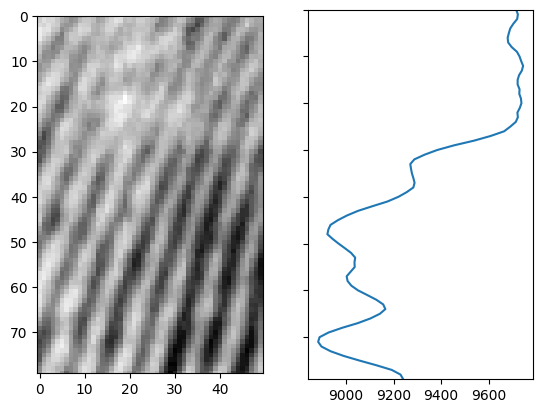

In [514]:
regionList, locMaxList, xSigList = fp.ridge_frequency(fingerprintsList)
show(regionList[0])
print(xSigList[0])
x = np.arange(regionList[0].shape[0])
f, axarr = plt.subplots(1, 2, sharey = True)
axarr[0].imshow(regionList[0], cmap = 'gray')
axarr[1].plot(xSigList[0], x)
axarr[1].set_ylim(regionList[0].shape[0] - 1, 0)
plt.show()

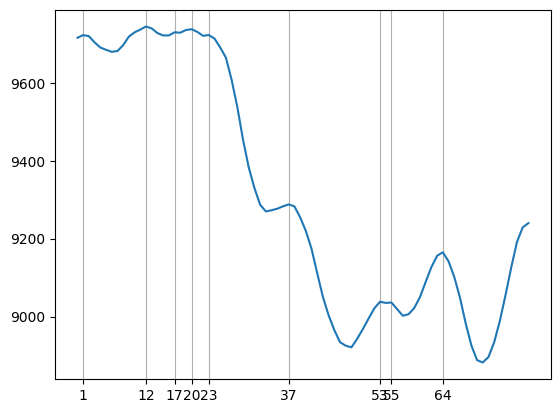

In [515]:
# Find the indices of the x-signature local maxima
plt.plot(x, xSigList[0])
plt.xticks(locMaxList[0])
plt.grid(True, axis='x')
plt.show()

In [516]:
distanceList, ridgePeriodList = fp.ridge_period(locMaxList)
distances = distanceList[0]
ridgePeriod = ridgePeriodList[0]
print("distance array of %s = %s" % (filename,distances))
print("average ridge period of %s = %s" % (filename, ridgePeriod))

distance array of 102_5.tif = [11  5  3  3 14 16  2  9]
average ridge period of 102_5.tif = 7.875


,,,,,,,
,,,,,,,

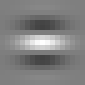
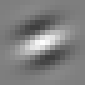
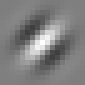
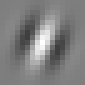
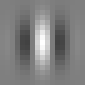
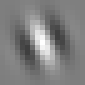
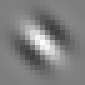
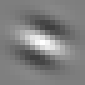

In [517]:
gaborBankList = fp.gabor_bank(ridgePeriodList)
gaborBank = gaborBankList[0]
#gaborBank2 = gaborBankList[1]


#print(gaborBank2)
#print(gaborBank2)
show(*gaborBank)

,,,,,,,,
,,,,,,,,

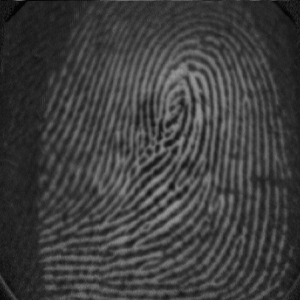
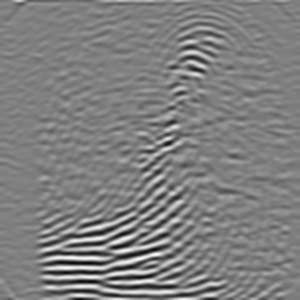
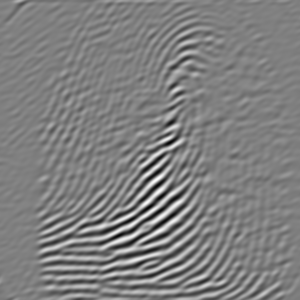
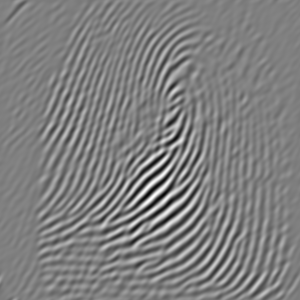
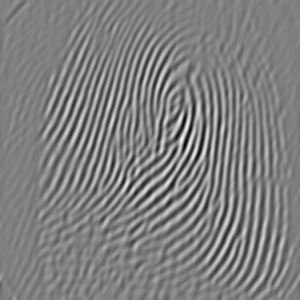
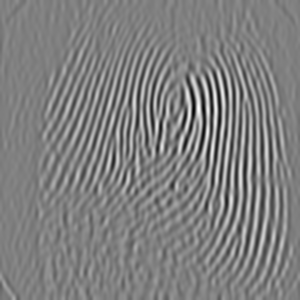
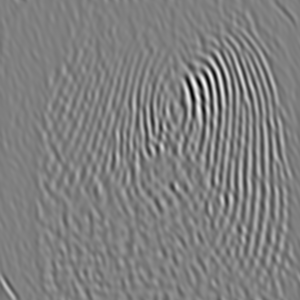
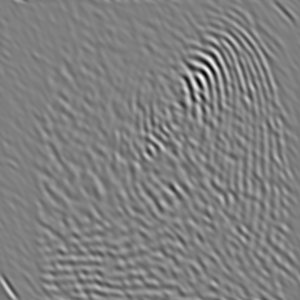
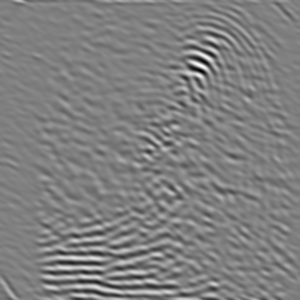

In [518]:
fFPList, nfFBList = fp.filter_fingerprint(fingerprintsList, gaborBankList)
show(nfFBList[0], *fFPList[0])

,
Original Fingerprint of 102_5.tif,Enhanced Fingerprint of 102_5.tif

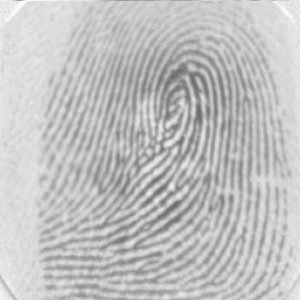
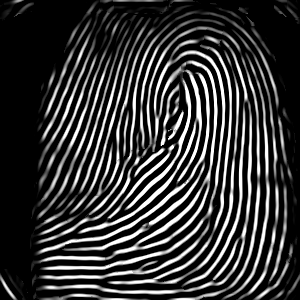

In [519]:
enhancedFPList  = fp.enhance_fingerprint(fingerprintsList, fFPList, orientationsList, maskList)
enhanced102_5, filename1 = enhancedFPList[0]
show((fingerprint, f'Original Fingerprint of {filename1}'), (enhanced102_5, f'Enhanced Fingerprint of {filename1}'))

##### Figure X:

In [520]:
ridgeLinesList = fp.ridge_lines(enhancedFPList)
ridgeLines = ridgeLinesList[0]
#show((fingerprint, f'Original Fingerprint of {filename}'), (ridgeLines, f'Enhanced Fingerprint of {filename}'), (cv.merge((ridgeLines, fingerprint, fingerprint)), f'Combined Image {filename}'))
print(type(ridgeLines), ridgeLines.dtype, ridgeLines.shape)

<class 'numpy.ndarray'> uint8 (300, 300)


,
,

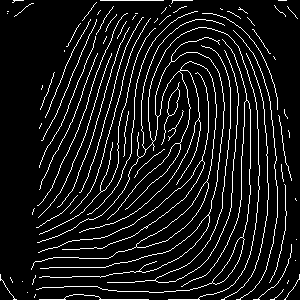
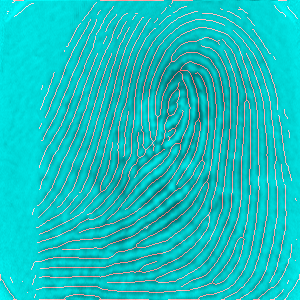

In [521]:
skeletonList = fp.get_skeleton(ridgeLinesList)
skeleton = skeletonList[0]
show(skeleton, cv.merge((fingerprint, fingerprint, skeleton)))

,,
,,

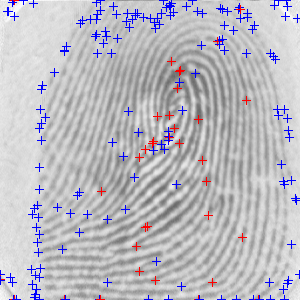
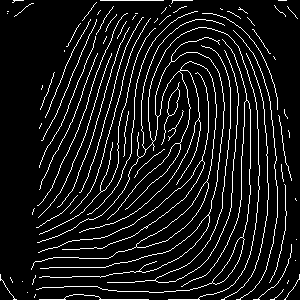
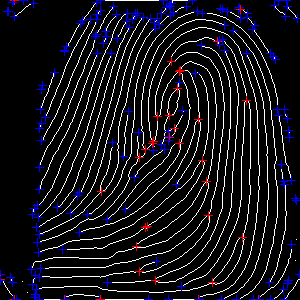

In [522]:
neighbourValsList, allEightNeighbors, cnList = fp.get_cn(skeletonList)
cn = cnList[0]
minutiaeList = fp.get_minutiae(cnList)
minutiae = minutiaeList[0]
show(draw_minutiae(fingerprint, minutiae), skeleton, draw_minutiae(skeleton, minutiae))

,
,

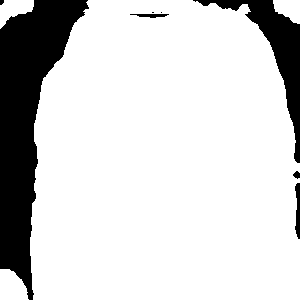
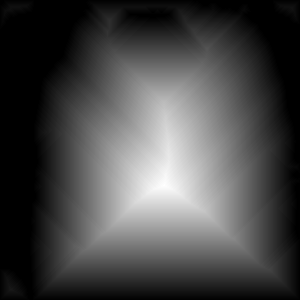

In [523]:
maskDistList = fp.get_mask_distance(maskList)
show(maskList[0], maskDistList[0])

,,
,,

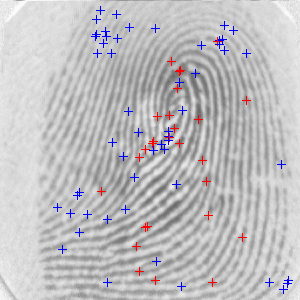
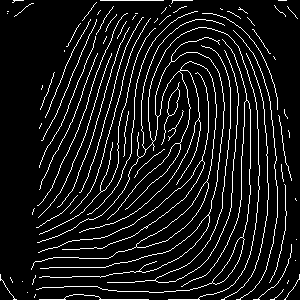
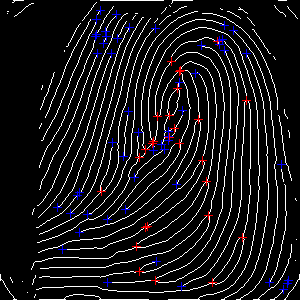

In [524]:
filtMinutiaeList = fp.get_filt_minutiae(maskDistList, minutiaeList)
filteredMinutiae = filtMinutiaeList[0]
show(draw_minutiae(fingerprint, filteredMinutiae), skeleton, draw_minutiae(skeleton, filteredMinutiae))

""
Valid Mintuiae of 102_5.tif

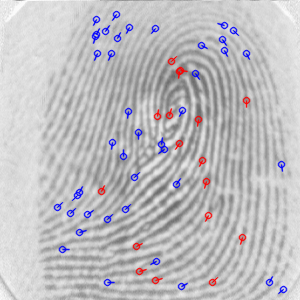

In [525]:
xySteps, ndLUT = fp.create_nd_LUT(allEightNeighbors)
#print(ndLUT)
classMinutiaeDir = fp.MinutiaeDirections(neighbourValsList, ndLUT, cnList, xySteps, fingerprintsList)
validMinutiaeList = classMinutiaeDir.valid_minutiae(filtMinutiaeList)
#validMinutiaeList = fp.valid_minutiae(ridgeCtx, filtMinutiaeList)
validMinutiae, filename = validMinutiaeList[0]
#print(validMinutiaeList[0])
show((draw_minutiae(fingerprint, validMinutiae), f'Valid Mintuiae of {filename}'))

In [526]:
classLocalStructs = fp.LocalStructs(validMinutiaeList)
localStructsList = classLocalStructs.create_local_structs()
validMinutiae, filename4 = validMinutiaeList[0]
localStructs, filename4 = localStructsList[0]

@interact(i=(0,len(validMinutiae)-1))
def test(i=0):
    show((draw_minutiae_and_cylinder(fingerprint, classLocalStructs.refCellCoords, validMinutiae , localStructs, i), \
        f'Local Structures of {filename4}'))

interactive(children=(IntSlider(value=0, description='i', max=57), Output()), _dom_classes=('widget-interact',…